Given two datasets from two different months, define the metric between them to be $\sum_{grid_x, grid_y} | d_1(grid_x, grid_y) - d_2(grid_x, grid_y)|$.

The small version of a data set contains 500,000 lines, which is about 3-5% of the original size.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from utils import geoutils
from utils import datautils

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

pd.options.mode.chained_assignment = None

In [2]:
# takes a raw (an output of read_rides) DataFrame, and counts the number of rides in each grid cell.
def counts_by_grid_cell(df):
    df = datautils.clean_rides(df)
    df = datautils.add_grid_cols(df)
    count = df.groupby(['grid_x', 'grid_y']).size()
    return count

# take the output of counts_by_grid_cell, multi-indexed by (grid_x, grid_y),
# and returns a matrix of shape (grid_x, grid_y).
def pivot_counts(counts):
    return counts.reset_index(name='count')\
        .pivot(index='grid_x', columns='grid_y', values='count')\
        .reindex(index=range(geoutils.NGRID_X), columns=range(geoutils.NGRID_Y))\
        .fillna(0)
# takes two raw rides DataFrames, and returns a matrix of differences in counts
# (abs value thereof) indexed by (grid_x, grid_y). This can be considered
# as a metric on the space of aggregated counts.
def counts_diff(df, df_other):
    counts = counts_by_grid_cell(df)
    counts = pivot_counts(counts)
    counts_other = counts_by_grid_cell(df_other)
    counts_other = pivot_counts(counts_other)
    counts_diff = counts - counts_other
    return np.abs(counts_diff)

In [3]:
def get_dist_matrix(csvs):
    dfs = [datautils.read_rides(file) for file in csvs]
    # compute aggregation here to avoid recomputing it in the loop.
    counts = [pivot_counts(counts_by_grid_cell(df)) for df in dfs]
    dists = np.zeros((len(dfs), len(dfs)))
    for i, c1 in enumerate(counts):
        for j, c2 in enumerate(counts):
            if i < j:
                dists[i, j] = np.abs(c1-c2).sum().sum()
                dists[j, i] = dists[i,j]
    return dists

In [48]:
# given rides data in an appropriate numpy format and a fit_transformed kemans object,
# returns the sum of distances from the points to their respective centers.
def get_dists_to_center(X, kmeans):
    dist_to_center = np.zeros(len(X))
    for i, label in enumerate(kmeans.labels_):
        center = kmeans.cluster_centers_[label]
        dist_to_center[i] = np.linalg.norm(X[i] - center)
    return dist_to_center

## 2014-2016 data:
1. Brute force:
2. KMeans:



In [ ]:
size='tiny'
data_file = 'data/yellow_tripdata_{0}-{1}_{2}.csv'
months_2016 = [('2016', f'{k:02}') for k in range(1,7)]
months_2015 = [('2015', f'{k:02}') for k in range(1,13)]
months_2014 = [('2014', f'{k:02}') for k in range(1,13)]
ym_tuples = months_2014 + months_2015 + months_2016
csvs = [data_file.format(y, m, size) 
        for y, m in ym_tuples]

### Brute Force

### KMeans

## 2015 and 2016 data:

Aug 2015 stands out for both methods.

1. Brute force: 5m18s
2. KMeans: 5m24s
3. tSNE: sub 1s. Not informative.

In [30]:
size='tiny'
data_file = 'data/yellow_tripdata_{0}-{1}_{2}.csv'
months_2016 = [('2016', f'{k:02}') for k in range(1,7)]
months_2015 = [('2015', f'{k:02}') for k in range(1,13)]
ym_tuples = months_2015 + months_2016
csvs = [data_file.format(y, m, size) 
        for y, m in ym_tuples]

### Brute force

In [23]:
%%time
dists = get_dist_matrix(csvs)

CPU times: user 5min 23s, sys: 1.38 s, total: 5min 25s
Wall time: 5min 25s


In [37]:
ym = [f'{t[0]}-{t[1]}' for t in ym_tuples]
s_dists = pd.Series(np.sum(dists, axis=1), index=ym, name='tot_dist')

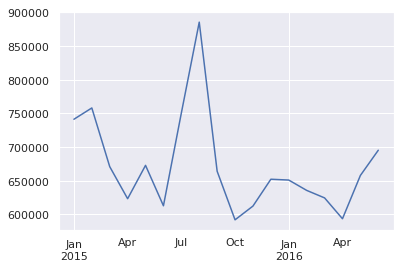

In [40]:
s_dists.index = pd.to_datetime(s_dists.index)
s_dists.plot()

### KMeans

In [18]:
%%time
X = np.array([np.ravel(pivot_counts(counts_by_grid_cell(datautils.read_rides(file))))\
             for file in csvs])
kmeans = KMeans(n_clusters=2, random_state=1).fit(X)

CPU times: user 5min 24s, sys: 2.04 s, total: 5min 26s
Wall time: 5min 26s


In [19]:
kmeans.labels_

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [47]:
dist_to_center = np.zeros(len(X))
for i, label in enumerate(kmeans.labels_):
    center = kmeans.cluster_centers_[label]
    dist_to_center[i] = np.linalg.norm(X[i] - center)
dist_to_center

array([1168.56060557, 1055.28111052, 1305.20619912, 1658.61640197,
       1870.27637055, 1254.04908286, 2090.17374929, 2888.64375943,
       1703.58967151, 1327.03445153, 1404.50946439, 1675.97680042,
       1676.31449979, 1757.82700198, 1511.56308796, 1247.08242265,
       1610.78073272, 1948.81701781])

In [41]:
kmeans.cluster_centers_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### tSNE

In [25]:
%%time
X_tsne = TSNE().fit_transform(X)

CPU times: user 315 ms, sys: 143 ms, total: 457 ms
Wall time: 340 ms


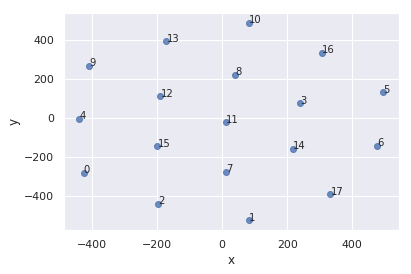

In [26]:
df = pd.DataFrame(X_tsne, columns=['x','y'])
# ax = sns.scatterplot(data=df) should work, but ax.text doesn't
# add annotations at the right coordinates.
ax = sns.regplot(x='x', y='y', fit_reg=False, data=df)
for i in range(df.shape[0]):
    ax.text(df.x[i] + 0.5, df.y[i], df.index[i])

## With 2016 data
With size=tiny, 2016-01 stands out, but with size=small, the months are evenly distant from each other.

Three approaches.

1. Brute force:
    1m48s for small.
2. KMeans:
    1m50s for small.
    As long as the aggregation is the most expensive part, this computation has the same complexity as the brute force method.
3. tSNE:
    Less than a second.

### Brute force
There aren't too many months anyway.
For each month, compute the sum of distances from other months.

For size=tiny, 2016-01 is far from others.
The result agrees with that of KMeans.

For size=small, the months are evenly spread out.

In [14]:
months = [f'{k:02}' for k in range(1,7)]
size='small'
csvs = [f'data/yellow_tripdata_2016-{m}_{size}.csv' for m in months]

In [15]:
%%time
dists = get_dist_matrix(csvs)

CPU times: user 1min 48s, sys: 342 ms, total: 1min 48s
Wall time: 1min 49s


In [16]:
dists

array([[    0., 28378., 30360., 32514., 38072., 41296.],
       [28378.,     0., 26208., 29586., 38266., 41830.],
       [30360., 26208.,     0., 28038., 37256., 37054.],
       [32514., 29586., 28038.,     0., 26338., 31796.],
       [38072., 38266., 37256., 26338.,     0., 29570.],
       [41296., 41830., 37054., 31796., 29570.,     0.]])

In [17]:
np.sum(dists, axis=1)

array([170620., 164268., 158916., 148272., 169502., 181546.])

### kmeans approach

In [18]:
months = [f'{k:02}' for k in range(1,7)]
size='small'
csvs = [f'data/yellow_tripdata_2016-{m}_{size}.csv' for m in months]

In [19]:
%%time
X = np.array([np.ravel(pivot_counts(counts_by_grid_cell(datautils.read_rides(file))))\
             for file in csvs])
kmeans = KMeans(n_clusters=2, random_state=1).fit(X)

CPU times: user 1min 50s, sys: 402 ms, total: 1min 50s
Wall time: 1min 50s


In [ ]:
kmeans.labels_

In [27]:
#kmeans.inertia_
kmeans.cluster_centers_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### tSNE visualization

In [20]:
%%time
X_tsne = TSNE().fit_transform(X)

CPU times: user 128 ms, sys: 16.8 ms, total: 145 ms
Wall time: 142 ms


In [21]:
X_tsne

array([[ 244.44173  ,  250.0363   ],
       [ 198.55652  ,  -17.62255  ],
       [ -70.17925  ,  -56.692142 ],
       [-190.38113  ,  186.81459  ],
       [   4.0617685,  376.3839   ],
       [  37.302067 ,  147.7844   ]], dtype=float32)

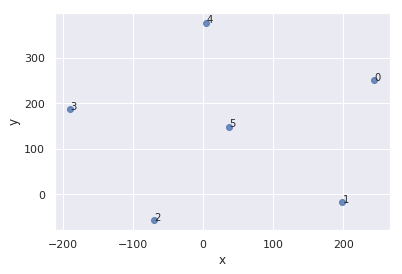

In [22]:
df = pd.DataFrame(X_tsne, columns=['x','y'])
# ax = sns.scatterplot(data=df) should work, but ax.text doesn't
# add annotations at the right coordinates.
ax = sns.regplot(x='x', y='y', fit_reg=False, data=df)
for i in range(df.shape[0]):
    ax.text(df.x[i] + 0.5, df.y[i], df.index[i])

In [3]:
df1 = datautils.read_rides('data/yellow_tripdata_2016-01_small.csv')
df6 = datautils.read_rides('data/yellow_tripdata_2016-06_small.csv')

In [4]:
# read_rides returns df[in_nyc], so subsequent slicing and setting raises a warning.
pd.options.mode.chained_assignment = None
diff = counts_diff(df1, df6)
pd.options.mode.chained_assignment = 'warn'

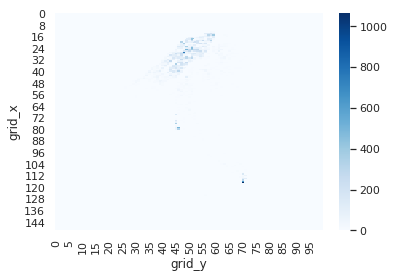

In [5]:
sns.heatmap(diff, cmap='Blues')

In [6]:
df1_counts = counts_by_grid_cell(df1)

/home/atkm/code/nyc-taxi/scikit/utils/datautils.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['grid_x'] = df.pickup_longitude.apply(geoutils._get_grid_cell_x)
/home/atkm/code/nyc-taxi/scikit/utils/datautils.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['grid_y'] = df.pickup_latitude.apply(geoutils._get_grid_cell_y)


In [7]:
df1_counts = pivot_counts(df1_counts)

In [10]:
df1_counts.

grid_y,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
grid_x,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
df1_counts.sort_values(ascending=False).head()

grid_x  grid_y
25      48        5284
30      49        4906
33      48        4676
32      47        4518
23      49        4299
dtype: int64

In [41]:
df6_counts = counts_by_grid_cell(df6)

/home/atkm/code/nyc-taxi/scikit/utils/datautils.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['grid_x'] = df.pickup_longitude.apply(geoutils._get_grid_cell_x)
/home/atkm/code/nyc-taxi/scikit/utils/datautils.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['grid_y'] = df.pickup_latitude.apply(geoutils._get_grid_cell_y)


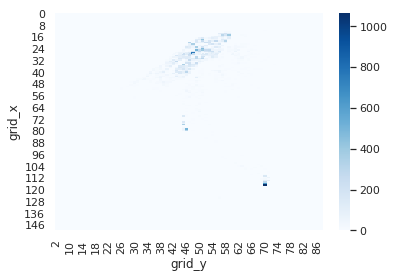

In [46]:
sns.heatmap(np.abs(counts_diff), cmap='Blues')

In [50]:
np.abs(counts_diff).sum?

In [51]:
np.abs(counts_diff).sum().sum()

41255.0